<a href="https://colab.research.google.com/github/GrzegorzMeller/AirlineServicesDB/blob/master/OCULAR_DISEASE_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip ODIR-5K.zip

In [0]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

In [10]:
train_N_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*N.jpg").repeat()
train_D_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*D.jpg").repeat()
train_G_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*G.jpg").repeat()
train_C_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*C.jpg").repeat()
train_A_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*A.jpg").repeat()
train_H_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*H.jpg").repeat()
train_M_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*M.jpg").repeat()
train_O_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*O.jpg").repeat()
train_MIX_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*X.jpg").repeat() #X = MIX
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

for f in train_MIX_ds.take(5):
  print(f.numpy())

for f in test_ds.take(5):
  print(f.numpy())

b'ODIR-5K/Training Images/1986_right-O&O&X.jpg'
b'ODIR-5K/Training Images/479_left-D&O&X.jpg'
b'ODIR-5K/Training Images/630_left-O&D&X.jpg'
b'ODIR-5K/Training Images/754_right-H&D&X.jpg'
b'ODIR-5K/Training Images/1718_left-D&O&X.jpg'
b'ODIR-5K/Validation_Images/1362_right-G.jpg'
b'ODIR-5K/Validation_Images/2845_left-N.jpg'
b'ODIR-5K/Validation_Images/1841_left-A.jpg'
b'ODIR-5K/Validation_Images/680_right-N.jpg'
b'ODIR-5K/Validation_Images/4690_right-D.jpg'


In [11]:
resampled1_ds = tf.data.experimental.sample_from_datasets([train_N_ds, train_D_ds, train_G_ds, train_C_ds, 
                                                          train_A_ds, train_H_ds, train_M_ds, train_O_ds, train_MIX_ds],
                                                         weights=[1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])

for f in resampled1_ds.take(10):
  print(f.numpy())

b'ODIR-5K/Training Images/543_left-H&D&X.jpg'
b'ODIR-5K/Training Images/1538_left-M.jpg'
b'ODIR-5K/Training Images/565_right-A.jpg'
b'ODIR-5K/Training Images/4050_left-D.jpg'
b'ODIR-5K/Training Images/732_right-O.jpg'
b'ODIR-5K/Training Images/4104_right-D.jpg'
b'ODIR-5K/Training Images/1281_left-G&D&X.jpg'
b'ODIR-5K/Training Images/2423_left-N.jpg'
b'ODIR-5K/Training Images/1282_left-G.jpg'
b'ODIR-5K/Training Images/1092_right-O.jpg'


In [0]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0, 0, 0, 0, 0, 0, 0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'D':
        l[1] = 1
      elif e == 'G':
        l[2] = 1
      elif e == 'C':
        l[3] = 1
      elif e == 'A':
        l[4] = 1
      elif e == 'H':
        l[5] = 1
      elif e == 'M':
        l[6] = 1
      elif e == 'O':
        l[7] = 1

  return l

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=1)
  #img = tf.image.adjust_contrast(img, 3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

(192, 256, 1)
label:  D [0 1 1 0 0 0 0 0]
(192, 256, 1)
label:  M [0 0 0 0 0 0 1 0]
(192, 256, 1)
label:  A [0 0 0 0 1 0 0 0]
(192, 256, 1)
label:  D [0 1 0 0 0 0 0 0]
(192, 256, 1)
label:  O [0 0 0 0 0 0 0 1]
(192, 256, 1)
label:  D [0 1 0 0 0 0 0 0]


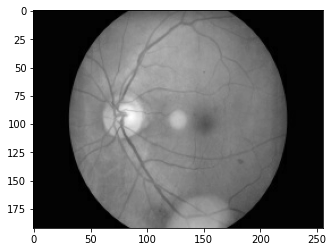

In [28]:
for image, label in resampled_named_ds.take(6):
  print(image.shape)
  plt.imshow(np.reshape(image.numpy(),(192, 256)), cmap='gray')
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [0]:
def randomly_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
  #image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  #ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.batch(800, drop_remainder=True) #all elemetnts for training should be batched in one!
  ds = ds.repeat()

  return ds

In [0]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=6000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

[0 0 0 0 0 0 0 1]


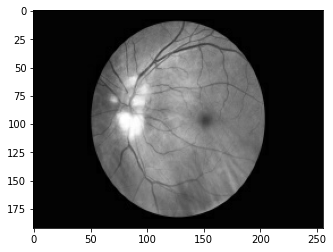

In [34]:
for example in final_train_ds.take(1):
  image, label = example
  break
im, lab = image[14], label[14]
plt.imshow(np.reshape(im.numpy(),(192, 256)), cmap='gray')
print(lab.numpy())

In [35]:
model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(32, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.5),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(128, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(8, activation = 'sigmoid')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 256, 32)      96        
_________________________________________________________________
activation (Activation)      (None, 192, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 256, 32)      96        
_________________________________________________________________
activation_1 (Activation)    (None, 192, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 128, 32)       0

In [36]:
history_cnn = model_cnn.fit(final_train_ds.repeat(),
                    #batch_size=32,
                    epochs=100,
                    steps_per_epoch = 163, #train_elements/batch_size
                    validation_data=final_test_ds.repeat(),
                    validation_steps = 1,
                    use_multiprocessing=True,
                    #class_weight=class_weight
                    )

Epoch 1/100
163/163 [==============================] - 20s 122ms/step - loss: 35.0249 - accuracy: 0.2452 - val_loss: 31.4776 - val_accuracy: 0.0388
Epoch 2/100
163/163 [==============================] - 17s 102ms/step - loss: 1.3332 - accuracy: 0.2521 - val_loss: 3.7495 - val_accuracy: 0.0375
Epoch 3/100
163/163 [==============================] - 17s 102ms/step - loss: 0.4388 - accuracy: 0.2749 - val_loss: 0.4330 - val_accuracy: 0.2362
Epoch 4/100
163/163 [==============================] - 17s 102ms/step - loss: 0.3760 - accuracy: 0.3227 - val_loss: 0.3871 - val_accuracy: 0.1988
Epoch 5/100
163/163 [==============================] - 17s 102ms/step - loss: 0.3533 - accuracy: 0.3635 - val_loss: 0.3807 - val_accuracy: 0.1538
Epoch 6/100
163/163 [==============================] - 17s 102ms/step - loss: 0.3471 - accuracy: 0.3900 - val_loss: 0.3683 - val_accuracy: 0.2275
Epoch 7/100
163/163 [==============================] - 17s 102ms/step - loss: 0.3356 - accuracy: 0.4095 - val_loss: 0.3584

KeyboardInterrupt: ignored

In [0]:
!rm -rf ODIR-5K/Validation_Images